# Model training demo

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import nnfabrik
from nnfabrik.builder import get_data, get_model, get_trainer
# import cascade

## Specifying the datasets

In [2]:
data_path = "/project/data/"

In [3]:
filenames = [
    f'{data_path}static21067-10-18-GrayImageNet-e174a2ed1deec79edcf87e2a33fbe9c5.zip',
#     f'{data_path}static21067-13-14-GrayImageNet-e174a2ed1deec79edcf87e2a33fbe9c5.zip',
#     f'{data_path}static21067-9-17-GrayImageNet-e174a2ed1deec79edcf87e2a33fbe9c5.zip',
#     f'{data_path}static22620-4-15-GrayImageNet-e174a2ed1deec79edcf87e2a33fbe9c5.zip',
#     f'{data_path}static22620-4-17-GrayImageNet-e174a2ed1deec79edcf87e2a33fbe9c5.zip',
#     f'{data_path}static22620-5-11-GrayImageNet-e174a2ed1deec79edcf87e2a33fbe9c5.zip',
#     f'{data_path}static22846-10-16-GrayImageNet-e174a2ed1deec79edcf87e2a33fbe9c5.zip',
#     f'{data_path}static22846-2-19-GrayImageNet-e174a2ed1deec79edcf87e2a33fbe9c5.zip',
#     f'{data_path}static22846-2-21-GrayImageNet-e174a2ed1deec79edcf87e2a33fbe9c5.zip',
#     f'{data_path}static22846-7-15-GrayImageNet-e174a2ed1deec79edcf87e2a33fbe9c5.zip',
#     f'{data_path}static23343-5-17-GrayImageNet-e174a2ed1deec79edcf87e2a33fbe9c5.zip',
#     f'{data_path}static23555-5-12-GrayImageNet-e174a2ed1deec79edcf87e2a33fbe9c5.zip',
#     f'{data_path}static23656-14-22-GrayImageNet-e174a2ed1deec79edcf87e2a33fbe9c5.zip',
#     f'{data_path}static23964-4-22-GrayImageNet-e174a2ed1deec79edcf87e2a33fbe9c5.zip'
]

## Generating the DataLoader objects

In [4]:
import os
import datajoint as dj

dj.config['database.user'] = os.environ['DJ_USERNAME']
dj.config['database.password'] = os.environ['DJ_PASSWORD']

In [5]:
dataset_fn = 'cascade.datasets.static_loaders'
dataset_config = {'paths': filenames,
                 'normalize': True,
                 'include_behavior': True,
                 'include_eye_position': True,
                 'batch_size': 128,
                 'exclude': None,
                 'file_tree': True,
                 }

dataloaders = get_data(dataset_fn, dataset_config)

Connecting mohammad@18.198.155.36:3306
/project/data/static21067-10-18-GrayImageNet-e174a2ed1deec79edcf87e2a33fbe9c5.zip does not exist locally. Trying to fetch.
Unzipping /project/data/static21067-10-18-GrayImageNet-e174a2ed1deec79edcf87e2a33fbe9c5.zip into /project/data


### Inspecting the content of the DataLoader

In [6]:
tier = 'train'
dataset_name = '21067-10-18'

images, responses = [], []
for batch in dataloaders[tier][dataset_name]:
    image_batch, response_batch = batch[:2]
    images.append(image_batch.squeeze().cpu().data.numpy())
    responses.append(response_batch.squeeze().cpu().data.numpy())
    
images = np.vstack(images)
responses = np.vstack(responses)

print('The \"{}\" set of dataset \"{}\" contains the responses of {} neurons to {} images'.format(tier, dataset_name, responses.shape[1], responses.shape[0]))

The "train" set of dataset "21067-10-18" contains the responses of 8372 neurons to 4473 images


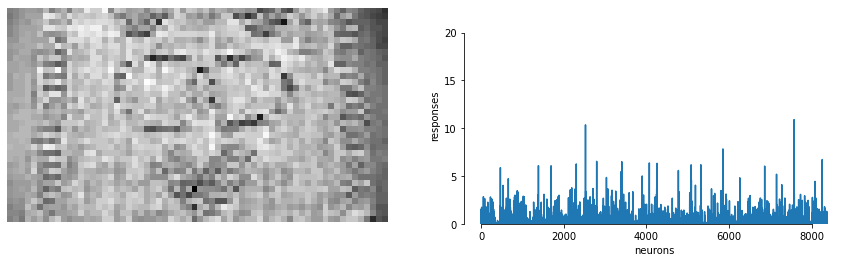

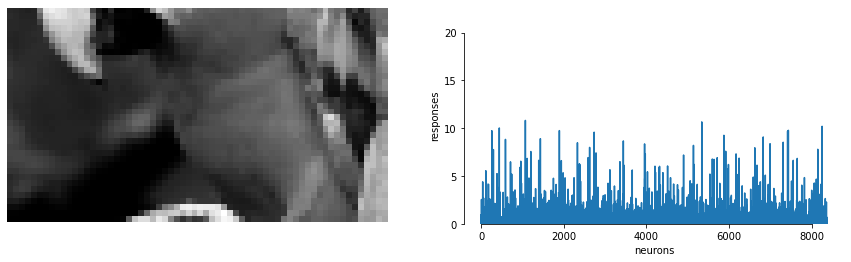

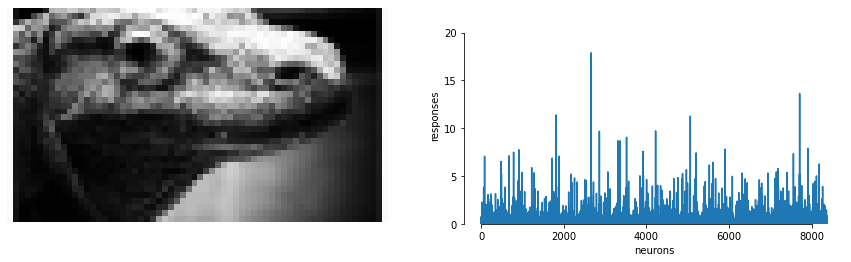

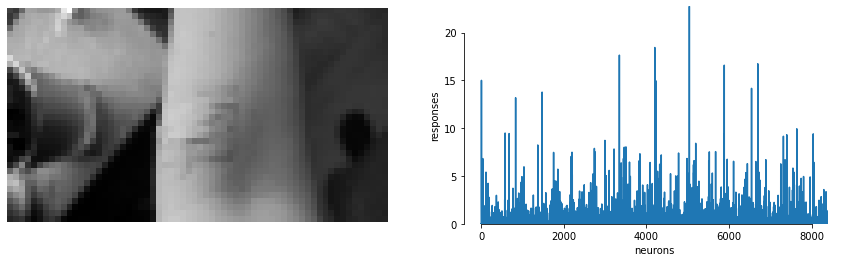

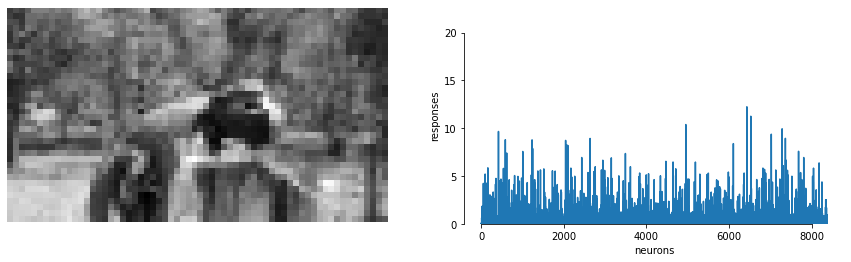

In [7]:
# show some example images and the neural responses
n_images = 5
max_response = responses[:n_images].max()

for i in range(n_images):
    fig, axs = plt.subplots(1, 2, figsize=(15,4))
    axs[0].imshow(images[i][0], cmap="gray")
    axs[0].axis("off")
    axs[1].plot(responses[i])
    axs[1].set_xlabel('neurons')
    axs[1].set_ylabel('responses')
    axs[1].set_ylim([0, max_response])
    sns.despine(trim=True)
    plt.show()

## Initializing the PyTorch Model

In [8]:
model_fn = 'cascade.models.stacked_core_full_gauss_readout'
model_config = {'pad_input': False,
               'stack': -1,
               'layers': 4,
               'input_kern': 9,
               'gamma_input': 6.3831,
               'gamma_readout': 0.0076,
               'hidden_dilation': 1,
               'hidden_kern': 7,
               'hidden_channels': 64,
               'depth_separable': True,
               'init_sigma': 0.1,
               'init_mu_range': 0.3,
               'gauss_type': 'full',
               'shifter': True,
               'shift_layers': 3,
               'depth_separable': True,
               }

model = get_model(model_fn=model_fn,
                  model_config=model_config,
                  dataloaders=dataloaders,
                  seed=1,)

/src/neuralpredictors/neuralpredictors/layers/readouts/base.py:62: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/src/neuralpredictors/neuralpredictors/layers/readouts/base.py:79: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")


## Specifying the Trainer Configuration

In [9]:
trainer_fn = "cascade.training.standard_trainer"

trainer_config = {'max_iter': 2,
                 'verbose': False,
                 'lr_decay_steps': 4,
                 'avg_loss': False,
                 'lr_init': 0.009,
                 }

trainer = get_trainer(trainer_fn=trainer_fn, 
                     trainer_config=trainer_config)

# Start Model Training

In [10]:
score1, output1, state_dict1 = trainer(model, dataloaders, seed=42)

Epoch 1: 100%|██████████| 35/35 [00:06<00:00,  5.11it/s]


[001|00/05] ---> 0.09979625046253204


Epoch 2: 100%|██████████| 35/35 [00:06<00:00,  5.14it/s]


[002|00/05] ---> 0.12839913368225098
Restoring best model! 0.128399 ---> 0.128399


---

# Model Evaluation

In [11]:
# import the data quality metrics
from cascade.utility.measures import get_conservative_oracles, get_SNR, get_explainable_var, get_jackknife_oracles, get_avg_firing

# import model evaluation metrics
from cascade.utility.scores import get_signal_correlations, get_correlations, get_FEV, get_fraction_oracles

#### Building the oracle DataLoader

This dataloader will return all repeats of one oracle image in a single batch

In [12]:
dataset_fn = 'cascade.datasets.static_loaders'
dataset_config["return_test_sampler"] = True

oracle_dataloaders = get_data(dataset_fn, dataset_config)

/project/data/static21067-10-18-GrayImageNet-e174a2ed1deec79edcf87e2a33fbe9c5 exists already. Not unpacking /project/data/static21067-10-18-GrayImageNet-e174a2ed1deec79edcf87e2a33fbe9c5.zip


In [13]:
def serialize_session_dict_into_df(session_dict, measure_attribute='score'):
    data_keys, values = [], []
    for key, unit_array in session_dict.item():
        for value in unit_array:
            data_keys.append(k)
            values.append(value)
    df = pd.DataFrame({'dataset':dks, measure_attribute:values})
    return df

# Conservative Oracle

In [14]:
c_oracles = get_conservative_oracles(oracle_dataloaders, as_dict=True, per_unit=True)

df = serialize_session_dict_into_df(session_dict=c_oracles,
                                    measure_attribute="conservative oracle correlation"
                                   )

TypeError: get_conservative_oracles() got an unexpected keyword argument 'per_unit'

### calculate plotting order of the boxen plots, by sorting by the best oracle score

In [43]:
data_keys, mean_oracles = [], []
for k,v in c_oracles.items():
    data_keys.append(k)
    mean_oracles.append(v.mean())
order = np.array(data_keys)[np.flipud(np.argsort(mean_oracles))]

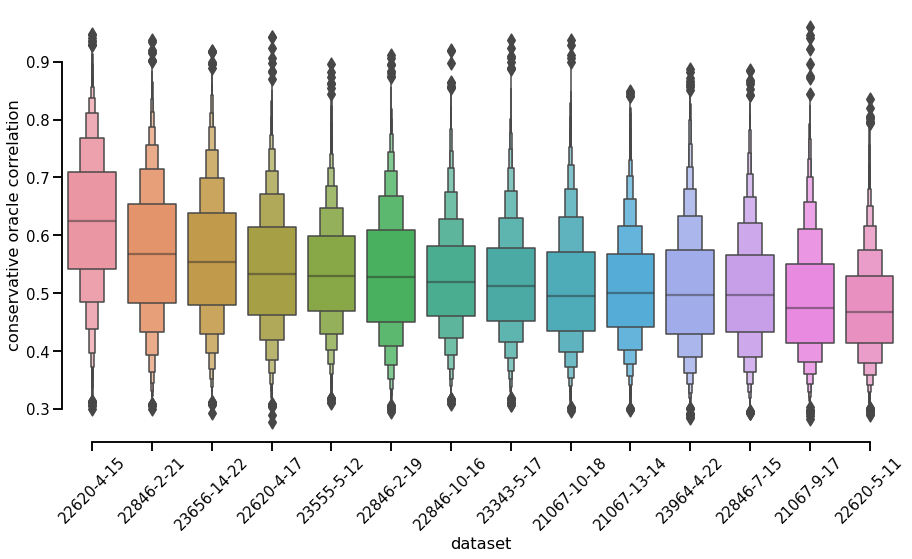

In [45]:
fig = plt.figure(figsize=(15,8))
sns.boxenplot(x="dataset", y="conservative oracle correlation", data=df, order=order)
plt.xticks(rotation = 45);
sns.despine(trim=True)


# Jackknife Oracle

In [53]:
jk_oracles = get_jackknife_oracles(oracle_dataloaders, as_dict=True, per_neuron=True)

df = serialize_session_dict_into_df(session_dict=jk_oracles,
                                    measure_attribute="jackknife oracle correlation"
                                   )

/notebooks/cascade/cascade/utility/measures.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(repeated_inputs), np.array(repeated_outputs)


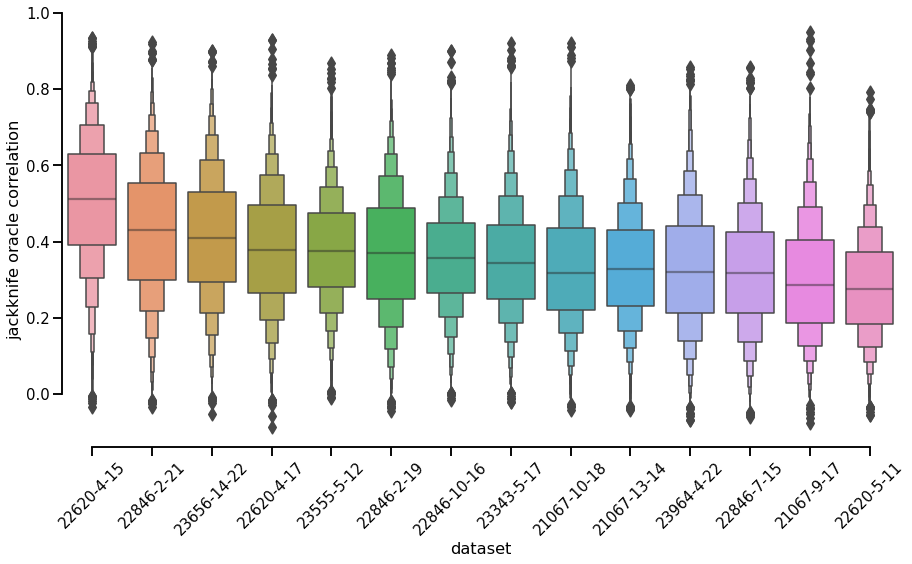

In [54]:
sns.set_context("talk", font_scale=0.9)
fig = plt.figure(figsize=(15,8))
sns.boxenplot(x="dataset", y="jackknife oracle correlation", data=df, order=order)
plt.xticks(rotation = 45);
sns.despine(trim=True)

# Explainable Variance

In [ ]:
expl_vars = get_explainable_var(oracle_dataloaders, as_dict=True, per_neuron=True)

df = serialize_session_dict_into_df(session_dict=expl_vars,
                                    measure_attribute="explainable variance"
                                   )

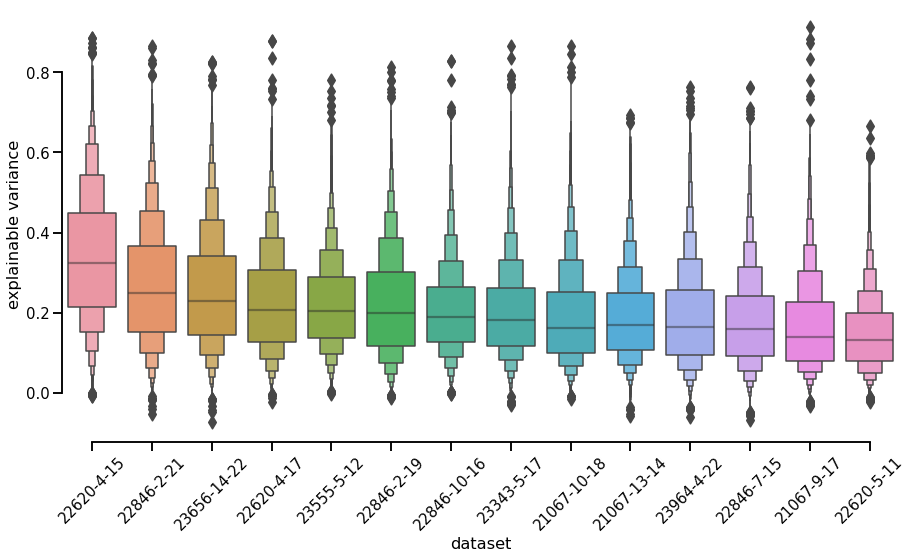

In [56]:
sns.set_context("talk", font_scale=0.9)
fig = plt.figure(figsize=(15,8))
sns.boxenplot(x="dataset", y="explainable variance", data=df, order=order)
plt.xticks(rotation = 45);
sns.despine(trim=True)

# Signal2Noise Ratio

In [48]:
snrs = get_SNR(oracle_dataloaders, as_dict=True, per_neuron=True)

df = serialize_session_dict_into_df(session_dict=snrs,
                                    measure_attribute="SNR"
                                   )

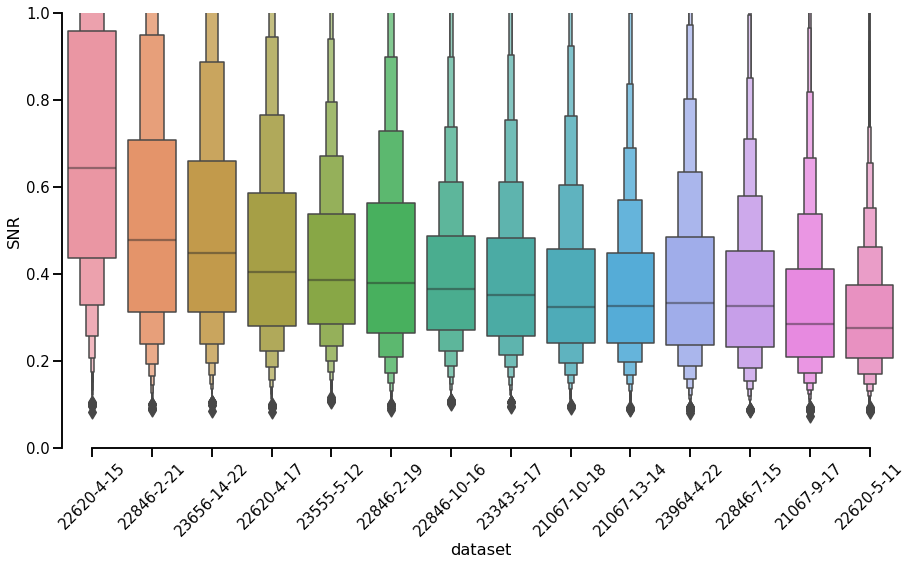

In [50]:
sns.set_context("talk", font_scale=0.9)
fig = plt.figure(figsize=(15,8))
sns.boxenplot(x="dataset", y="SNR", data=df, order=order)
plt.xticks(rotation = 45);
plt.ylim([0,1])
sns.despine(trim=True)


# Test correlation

a.k.a single trial test correlation

In [ ]:
test_corrs = get_correlations(model, oracle_dataloaders, device="cuda", as_dict=True)

df = serialize_session_dict_into_df(session_dict=test_corrs,
                                    measure_attribute="test correlation")

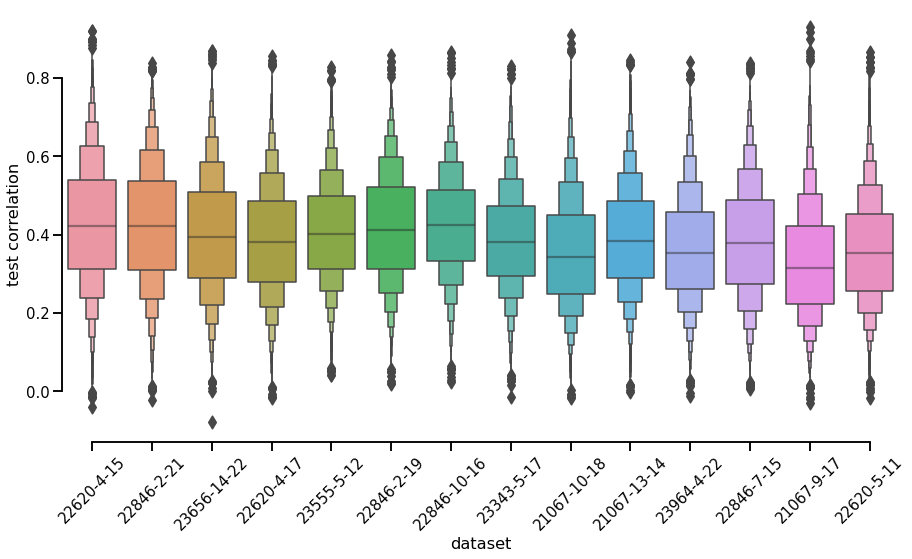

In [52]:
fig = plt.figure(figsize=(15,8))
sns.boxenplot(x="dataset", y="test correlation", data=df, order=order)
plt.xticks(rotation = 45);
sns.despine(trim=True)

# Signal Correlation

a.k.a correlation to the average across repeats

In [62]:
signal_corrs = get_signal_correlations(model, oracle_dataloaders, device="cuda", as_dict=True)

df = serialize_session_dict_into_df(session_dict=signal_corrs,
                                    measure_attribute="signal correlation")

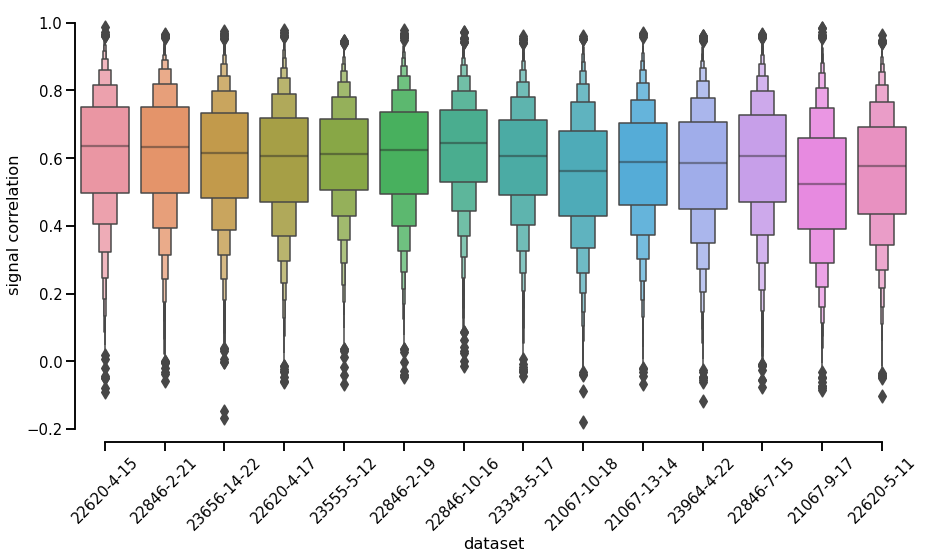

In [64]:
fig = plt.figure(figsize=(15,8))
sns.boxenplot(x="dataset", y="signal correlation", data=df, order=order)
plt.xticks(rotation = 45);
sns.despine(trim=True)